In [89]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2


In [2]:
data = pd.read_csv("match_data_v5.csv")
# drops missing values
data.dropna()


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29
0,EUW1_6882489515',2,23,4,2,0,0,0,7,0,...,2,0,1,400,94,29637,32613,27239,1,0
1,EUW1_6882416210',2,46,12,1,0,1,0,10,0,...,1,0,4,373,76,28970,30320,36585,0,0
2,EUW1_6881092720',2,19,13,0,0,0,0,11,0,...,2,0,3,340,84,30510,29464,42984,0,0
3,EUW1_6879405717',3,28,8,0,1,1,0,9,1,...,0,0,5,378,87,25157,31069,28229,0,0
4,EUW1_6879389461',3,30,11,1,1,1,0,7,0,...,1,0,5,382,96,26052,29475,19245,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24220,EUW1_6879062849',0,27,1,1,0,0,0,5,0,...,0,0,0,370,102,26134,30760,22845,0,0
24221,EUW1_6878994449',4,29,5,0,0,0,0,4,0,...,1,0,2,365,80,25169,30857,29694,0,0
24222,EUW1_6878933095',1,25,16,1,1,1,0,11,0,...,1,0,4,342,81,30528,29566,36545,0,0
24223,EUW1_6883217488',4,27,15,0,0,1,0,9,0,...,2,0,2,341,74,31761,30573,42858,0,0


## Data Pre-Processing

In [3]:
# remove instances where plates destroyed and towers destroyed don't line up
data = data[data.iloc[:, 20] > (data.iloc[:, 8] - 12)]
data = data[data.iloc[:, 22] > (data.iloc[:, 6] - 12)]

# there are only 15 plates in a match, remove instances where more than 15 plates are destroyed
data = data[data.iloc[:, 8] <= 15]
data = data[data.iloc[:, 22] <= 15]

# remove instances with more than 70 wards placed, greater than 70 are outliers
data = data[data.iloc[:, 2] <= 70]

In [4]:
data.columns = [
    "matchID", "blue_control_wards", "blue_wards", "blue_kills", "blue_dragons", "blue_heralds",
    "blue_towers", "blue_inhibs", "red_plates", "blue_first_blood", "blue_minions",
    "blue_jungle", "blue_gold", "blue_xp", "blue_dmg", "red_control_wards",
    "red_wards", "red_kills", "red_dragons", "red_heralds", "red_towers",
    "red_inhibs", "blue_plates", "red_minions", "red_jungle", "red_gold",
    "red_xp", "red_dmg", "blue_win", "null"
]

# drop unnecessary id and empty column
data = data.drop(columns=["matchID"])
data = data.drop(columns=["null"])

data.head()

,blue_control_wards,blue_wards,blue_kills,blue_dragons,blue_heralds,blue_towers,blue_inhibs,red_plates,blue_first_blood,blue_minions,...,red_heralds,red_towers,red_inhibs,blue_plates,red_minions,red_jungle,red_gold,red_xp,red_dmg,blue_win
0,2,23,4,2,0,0,0,7,0,388,...,0,2,0,1,400,94,29637,32613,27239,1
1,2,46,12,1,0,1,0,10,0,348,...,0,1,0,4,373,76,28970,30320,36585,0
2,2,19,13,0,0,0,0,11,0,331,...,0,2,0,3,340,84,30510,29464,42984,0
3,3,28,8,0,1,1,0,9,1,355,...,0,0,0,5,378,87,25157,31069,28229,0
4,3,30,11,1,1,1,0,7,0,370,...,0,1,0,5,382,96,26052,29475,19245,1


In [5]:
corr = data.corr()
corr["blue_win"].sort_values(ascending=False)

blue_win              1.000000
blue_gold             0.451825
blue_xp               0.434904
blue_kills            0.389112
blue_plates           0.321951
blue_dragons          0.315154
blue_towers           0.312680
blue_dmg              0.286868
blue_minions          0.239813
blue_jungle           0.203369
blue_first_blood      0.167305
blue_heralds          0.104679
blue_control_wards    0.054371
blue_inhibs           0.037322
blue_wards            0.022424
red_wards            -0.000073
red_inhibs           -0.009278
red_control_wards    -0.054340
red_heralds          -0.107104
red_jungle           -0.200527
red_towers           -0.241999
red_plates           -0.242901
red_minions          -0.259386
red_dmg              -0.276295
red_dragons          -0.308564
red_kills            -0.371216
red_xp               -0.431990
red_gold             -0.437823
Name: blue_win, dtype: float64

In [6]:
# drop those with abs(corr) less than 0.1
data = data.drop(columns=["blue_control_wards"])
data = data.drop(columns=["blue_inhibs"])
data = data.drop(columns=["blue_wards"])
data = data.drop(columns=["red_control_wards"])
data = data.drop(columns=["red_inhibs"])
data = data.drop(columns=["red_wards"])

data.describe()

,blue_kills,blue_dragons,blue_heralds,blue_towers,red_plates,blue_first_blood,blue_minions,blue_jungle,blue_gold,blue_xp,...,red_dragons,red_heralds,red_towers,blue_plates,red_minions,red_jungle,red_gold,red_xp,red_dmg,blue_win
count,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,...,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000,20088.000000
mean,12.834926,0.744873,0.126294,0.662236,8.364994,0.513590,351.145958,88.425478,27885.272252,29654.898945,...,0.894663,0.096326,0.876593,3.969883,349.559040,88.245022,27557.553365,29535.489148,31847.767523,0.512296
std,4.919872,0.723530,0.332339,0.894696,2.599595,0.499828,30.955731,14.040551,2744.487275,1858.174411,...,0.746879,0.295045,0.917763,2.612727,31.666999,13.993267,2574.101185,1873.576445,5921.364220,0.499861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,17719.000000,19061.000000,...,0.000000,0.000000,0.000000,0.000000,188.000000,0.000000,18247.000000,17602.000000,10383.000000,0.000000
25%,9.000000,0.000000,0.000000,0.000000,7.000000,0.000000,331.000000,79.000000,25960.000000,28421.000000,...,0.000000,0.000000,0.000000,2.000000,329.000000,79.000000,25787.750000,28326.000000,27788.000000,0.000000
50%,12.000000,1.000000,0.000000,0.000000,8.000000,1.000000,352.000000,88.000000,27718.000000,29659.000000,...,1.000000,0.000000,1.000000,4.000000,351.000000,88.000000,27426.500000,29558.000000,31641.000000,1.000000
75%,16.000000,1.000000,0.000000,1.000000,10.000000,1.000000,373.000000,98.000000,29630.000000,30907.250000,...,1.000000,0.000000,1.000000,6.000000,371.000000,97.000000,29198.000000,30763.000000,35695.000000,1.000000
max,38.000000,2.000000,2.000000,10.000000,15.000000,1.000000,465.000000,156.000000,40968.000000,36801.000000,...,2.000000,1.000000,8.000000,15.000000,464.000000,156.000000,40168.000000,36431.000000,62452.000000,1.000000


In [7]:
X = data.drop(["blue_win"], axis=1)
y = data["blue_win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

column = X_train.columns

scaler = StandardScaler().fit(X_train)
X_train_scale = pd.DataFrame(scaler.transform(X_train), columns = column)
X_test_scale = pd.DataFrame(scaler.transform(X_test), columns = column)

y_2d_train = np.reshape(y_train, (y_train.shape[0], 1))
y_2d_test = np.reshape(y_test, (y_test.shape[0], 1))

print(X_train_scale)
# print(y_2d_train)

       blue_kills  blue_dragons  blue_heralds  blue_towers  red_plates  \
0        1.849184      0.349457     -0.383535     1.489819   -0.908428   
1       -0.174056      0.349457     -0.383535    -0.741245    0.246736   
2        1.242212      0.349457     -0.383535     0.374287   -0.908428   
3       -0.781028      0.349457     -0.383535    -0.741245   -0.138319   
4       -0.983352      0.349457     -0.383535    -0.741245   -0.138319   
...           ...           ...           ...          ...         ...   
15061    0.028268      1.732049     -0.383535    -0.741245   -1.293483   
15062    0.432916      0.349457     -0.383535    -0.741245   -0.523374   
15063   -0.174056      1.732049     -0.383535    -0.741245   -1.678538   
15064   -1.590324      1.732049     -0.383535    -0.741245   -0.523374   
15065   -0.578704     -1.033136     -0.383535     0.374287    1.401900   

       blue_first_blood  blue_minions  blue_jungle  blue_gold   blue_xp  ...  \
0              0.969662      0.

## PCA

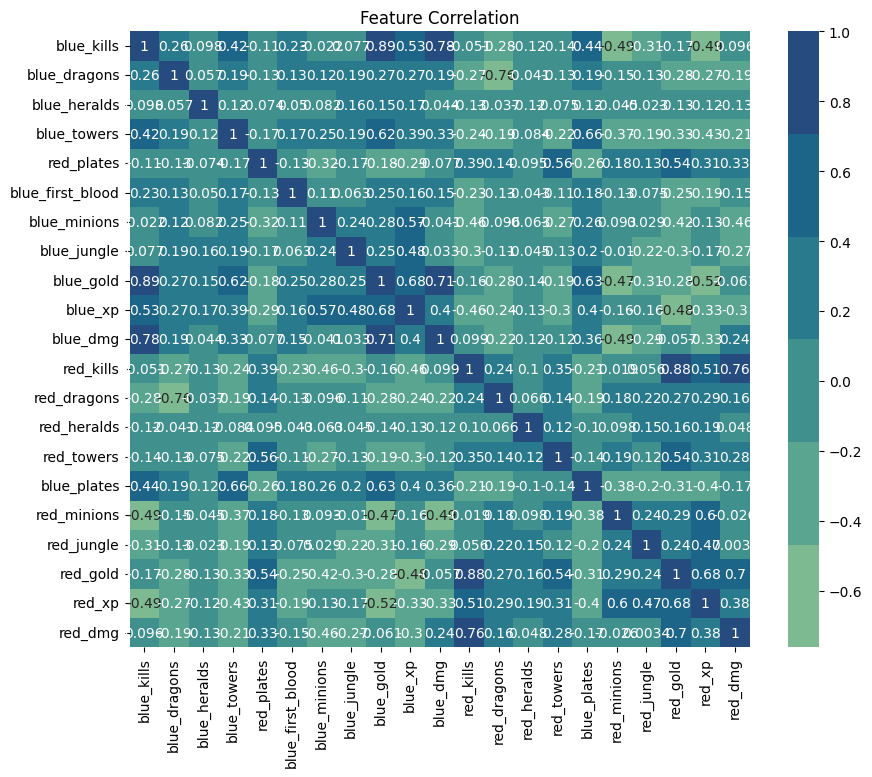

In [8]:
corr = X_train_scale.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True, cmap=sns.color_palette("crest"),edgecolor="k")
plt.title("Feature Correlation")
plt.show()

In [9]:
pca = PCA(n_components=1)

features = X_train_scale[['blue_kills', 'blue_gold', "blue_dmg"]]
principal_component = pca.fit_transform(features)
X_train_scale["blue_kills_gold_dmg"] = principal_component

features = X_train_scale[['red_kills', 'red_gold', "red_dmg"]]
principal_component = pca.fit_transform(features)
X_train_scale["red_kills_gold_dmg"] = principal_component

features = X_train_scale[['blue_xp', 'blue_minions', "blue_jungle", "blue_gold"]]
principal_component = pca.fit_transform(features)
X_train_scale["blue_xp_minions_jungle_gold"] = principal_component

features = X_train_scale[['red_xp', 'red_minions', "red_jungle", "red_gold"]]
principal_component = pca.fit_transform(features)
X_train_scale["red_xp_minions_jungle_gold"] = principal_component

features = X_train_scale[['red_plates', 'red_gold', 'red_towers']]
principal_component = pca.fit_transform(features)
X_train_scale["red_plates_gold_towers"] = principal_component

features = X_train_scale[['blue_plates', 'blue_gold', 'blue_towers']]
principal_component = pca.fit_transform(features)
X_train_scale["blue_plates_gold_towers"] = principal_component

X_train_scale = X_train_scale.drop(columns = ["blue_kills"])
X_train_scale = X_train_scale.drop(columns = ["blue_gold"])
X_train_scale = X_train_scale.drop(columns = ["blue_dmg"])
X_train_scale = X_train_scale.drop(columns = ["blue_xp"])
X_train_scale = X_train_scale.drop(columns = ["blue_minions"])
X_train_scale = X_train_scale.drop(columns = ["blue_jungle"])
X_train_scale = X_train_scale.drop(columns = ["blue_plates"])
X_train_scale = X_train_scale.drop(columns = ["blue_towers"])
X_train_scale = X_train_scale.drop(columns = ["red_kills"])
X_train_scale = X_train_scale.drop(columns = ["red_gold"])
X_train_scale = X_train_scale.drop(columns = ["red_dmg"])
X_train_scale = X_train_scale.drop(columns = ["red_xp"])
X_train_scale = X_train_scale.drop(columns = ["red_minions"])
X_train_scale = X_train_scale.drop(columns = ["red_jungle"])
X_train_scale = X_train_scale.drop(columns = ["red_plates"])
X_train_scale = X_train_scale.drop(columns = ["red_towers"])

print(X_train_scale)

       blue_dragons  blue_heralds  blue_first_blood  red_dragons  red_heralds  \
0          0.349457     -0.383535          0.969662     0.142975    -0.323460   
1          0.349457     -0.383535          0.969662    -1.198281     3.091571   
2          0.349457     -0.383535         -1.031287    -1.198281    -0.323460   
3          0.349457     -0.383535          0.969662    -1.198281    -0.323460   
4          0.349457     -0.383535          0.969662     0.142975     3.091571   
...             ...           ...               ...          ...          ...   
15061      1.732049     -0.383535         -1.031287    -1.198281    -0.323460   
15062      0.349457     -0.383535          0.969662     0.142975    -0.323460   
15063      1.732049     -0.383535         -1.031287    -1.198281    -0.323460   
15064      1.732049     -0.383535         -1.031287    -1.198281    -0.323460   
15065     -1.033136     -0.383535          0.969662     1.484231    -0.323460   

       blue_kills_gold_dmg 

In [10]:
pca = PCA(n_components=1)

features = X_test_scale[['blue_kills', 'blue_gold', "blue_dmg"]]
principal_component = pca.fit_transform(features)
X_test_scale["blue_kills_gold_dmg"] = principal_component

features = X_test_scale[['red_kills', 'red_gold', "red_dmg"]]
principal_component = pca.fit_transform(features)
X_test_scale["red_kills_gold_dmg"] = principal_component

features = X_test_scale[['blue_xp', 'blue_minions', "blue_jungle", "blue_gold"]]
principal_component = pca.fit_transform(features)
X_test_scale["blue_xp_minions_jungle_gold"] = principal_component

features = X_test_scale[['red_xp', 'red_minions', "red_jungle", "red_gold"]]
principal_component = pca.fit_transform(features)
X_test_scale["red_xp_minions_jungle_gold"] = principal_component

features = X_test_scale[['red_plates', 'red_gold', 'red_towers']]
principal_component = pca.fit_transform(features)
X_test_scale["red_plates_gold_towers"] = principal_component

features = X_test_scale[['blue_plates', 'blue_gold', 'blue_towers']]
principal_component = pca.fit_transform(features)
X_test_scale["blue_plates_gold_towers"] = principal_component

X_test_scale = X_test_scale.drop(columns = ["blue_kills"])
X_test_scale = X_test_scale.drop(columns = ["blue_gold"])
X_test_scale = X_test_scale.drop(columns = ["blue_dmg"])
X_test_scale = X_test_scale.drop(columns = ["blue_xp"])
X_test_scale = X_test_scale.drop(columns = ["blue_minions"])
X_test_scale = X_test_scale.drop(columns = ["blue_jungle"])
X_test_scale = X_test_scale.drop(columns = ["blue_plates"])
X_test_scale = X_test_scale.drop(columns = ["blue_towers"])
X_test_scale = X_test_scale.drop(columns = ["red_kills"])
X_test_scale = X_test_scale.drop(columns = ["red_gold"])
X_test_scale = X_test_scale.drop(columns = ["red_dmg"])
X_test_scale = X_test_scale.drop(columns = ["red_xp"])
X_test_scale = X_test_scale.drop(columns = ["red_minions"])
X_test_scale = X_test_scale.drop(columns = ["red_jungle"])
X_test_scale = X_test_scale.drop(columns = ["red_plates"])
X_test_scale = X_test_scale.drop(columns = ["red_towers"])

print(X_test_scale)

      blue_dragons  blue_heralds  blue_first_blood  red_dragons  red_heralds  \
0        -1.033136     -0.383535         -1.031287     0.142975    -0.323460   
1         1.732049     -0.383535          0.969662    -1.198281    -0.323460   
2         0.349457     -0.383535          0.969662     0.142975     3.091571   
3         0.349457     -0.383535         -1.031287     0.142975    -0.323460   
4        -1.033136     -0.383535          0.969662     1.484231     3.091571   
...            ...           ...               ...          ...          ...   
5017      0.349457     -0.383535         -1.031287    -1.198281    -0.323460   
5018      1.732049     -0.383535          0.969662    -1.198281    -0.323460   
5019     -1.033136     -0.383535         -1.031287     1.484231     3.091571   
5020     -1.033136     -0.383535         -1.031287    -1.198281    -0.323460   
5021      0.349457     -0.383535          0.969662     0.142975    -0.323460   

      blue_kills_gold_dmg  red_kills_go

In [11]:
X_train_scale['kills_gold_dmg_difference'] = X_train_scale["blue_kills_gold_dmg"] - X_train_scale["red_kills_gold_dmg"]
X_train_scale['xp_minions_jungle_gold_difference'] = X_train_scale['blue_xp_minions_jungle_gold'] - X_train_scale['red_xp_minions_jungle_gold']
X_train_scale['plates_gold_towers_difference'] = X_train_scale["blue_plates_gold_towers"] - X_train_scale["red_plates_gold_towers"]
X_train_scale['dragons_difference'] = X_train_scale['blue_dragons'] - X_train_scale['red_dragons']
X_train_scale['heralds_difference'] = X_train_scale["blue_heralds"] - X_train_scale["red_heralds"]
X_train_scale['first_blood_difference'] = X_train_scale['blue_first_blood'] * 2 - 1

X_train_scale = X_train_scale.drop(columns = ["blue_kills_gold_dmg"])
X_train_scale = X_train_scale.drop(columns = ["red_kills_gold_dmg"])
X_train_scale = X_train_scale.drop(columns = ['blue_xp_minions_jungle_gold'])
X_train_scale = X_train_scale.drop(columns = ["red_xp_minions_jungle_gold"])
X_train_scale = X_train_scale.drop(columns = ["blue_plates_gold_towers"])
X_train_scale = X_train_scale.drop(columns = ["red_plates_gold_towers"])
X_train_scale = X_train_scale.drop(columns = ['blue_dragons'])
X_train_scale = X_train_scale.drop(columns = ['red_dragons'])
X_train_scale = X_train_scale.drop(columns = ["blue_heralds"])
X_train_scale = X_train_scale.drop(columns = ["red_heralds"])
X_train_scale = X_train_scale.drop(columns = ['blue_first_blood'])

print(X_train_scale)


       kills_gold_dmg_difference  xp_minions_jungle_gold_difference  \
0                       4.942162                          -4.710615   
1                      -1.448487                           3.191232   
2                       2.612787                          -1.380285   
3                      -1.468442                           1.692398   
4                      -3.016998                           3.295161   
...                          ...                                ...   
15061                  -0.346421                           1.010103   
15062                  -0.802386                          -0.382803   
15063                  -1.109315                          -0.308597   
15064                  -2.273743                           0.391622   
15065                   2.232239                          -1.715903   

       plates_gold_towers_difference  dragons_difference  heralds_difference  \
0                           4.415918            0.206482           

In [12]:
X_test_scale['kills_gold_dmg_difference'] = X_test_scale["blue_kills_gold_dmg"] - X_test_scale["red_kills_gold_dmg"]
X_test_scale['xp_minions_jungle_gold_difference'] = X_test_scale['blue_xp_minions_jungle_gold'] - X_test_scale['red_xp_minions_jungle_gold']
X_test_scale['plates_gold_towers_difference'] = X_test_scale["blue_plates_gold_towers"] - X_test_scale["red_plates_gold_towers"]
X_test_scale['dragons_difference'] = X_test_scale['blue_dragons'] - X_test_scale['red_dragons']
X_test_scale['heralds_difference'] = X_test_scale["blue_heralds"] - X_test_scale["red_heralds"]
X_test_scale['first_blood_difference'] = X_test_scale['blue_first_blood'] * 2 - 1

X_test_scale = X_test_scale.drop(columns = ["blue_kills_gold_dmg"])
X_test_scale = X_test_scale.drop(columns = ["red_kills_gold_dmg"])
X_test_scale = X_test_scale.drop(columns = ['blue_xp_minions_jungle_gold'])
X_test_scale = X_test_scale.drop(columns = ["red_xp_minions_jungle_gold"])
X_test_scale = X_test_scale.drop(columns = ["blue_plates_gold_towers"])
X_test_scale = X_test_scale.drop(columns = ["red_plates_gold_towers"])
X_test_scale = X_test_scale.drop(columns = ['blue_dragons'])
X_test_scale = X_test_scale.drop(columns = ['red_dragons'])
X_test_scale = X_test_scale.drop(columns = ["blue_heralds"])
X_test_scale = X_test_scale.drop(columns = ["red_heralds"])
X_test_scale = X_test_scale.drop(columns = ['blue_first_blood'])

print(X_test_scale)


      kills_gold_dmg_difference  xp_minions_jungle_gold_difference  \
0                     -4.305841                           4.944571   
1                      1.690168                           0.378126   
2                     -0.090613                           0.621219   
3                      0.995500                          -2.826449   
4                     -1.321695                           4.300171   
...                         ...                                ...   
5017                   0.786184                          -0.873256   
5018                   1.675848                          -0.875021   
5019                  -1.531113                           2.080014   
5020                  -0.004732                           0.131941   
5021                  -1.570598                           1.593588   

      plates_gold_towers_difference  dragons_difference  heralds_difference  \
0                         -5.536619           -1.176111           -0.060075   
1

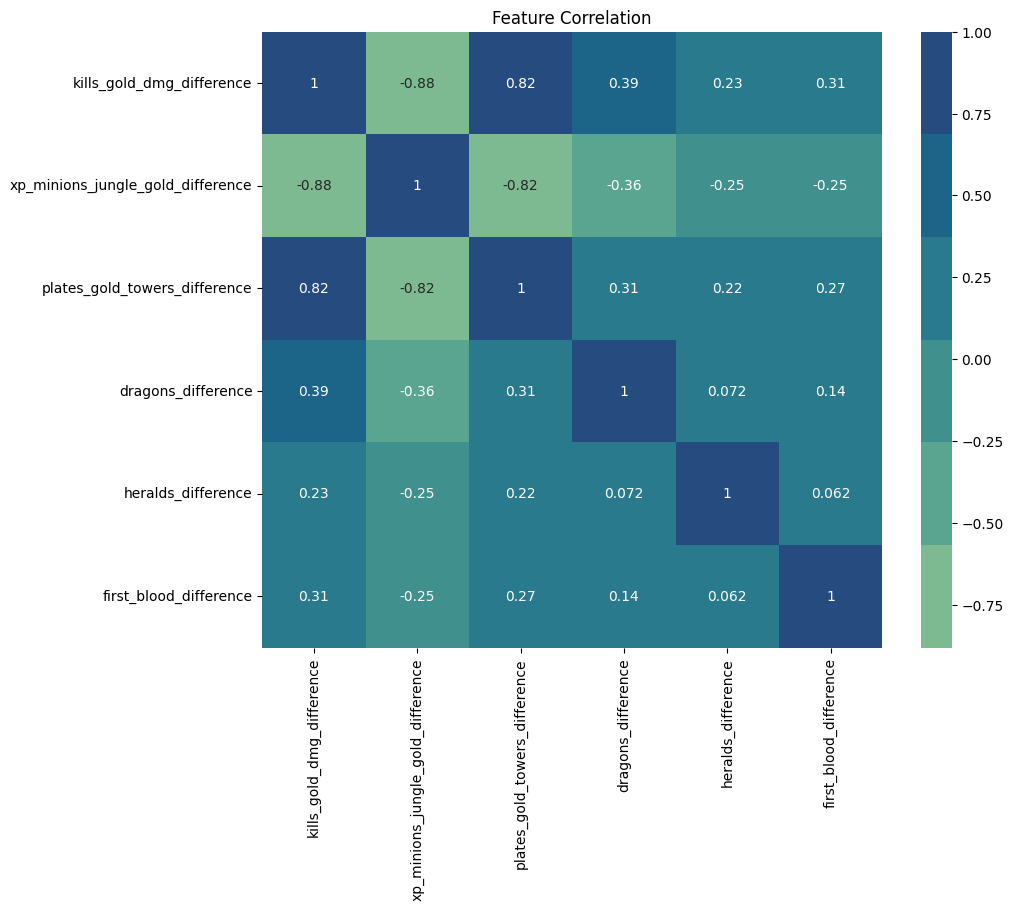

In [13]:
corr = X_train_scale.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True, cmap=sns.color_palette("crest"),edgecolor="k")
plt.title("Feature Correlation")
plt.show()

In [14]:
X_train_scale = X_train_scale.to_numpy()
X_test_scale = X_test_scale.to_numpy()

print(X_train_scale)
print(X_test_scale)

[[ 4.94216191 -4.71061536  4.41591835  0.20648187 -0.06007518  0.9393243 ]
 [-1.44848748  3.1912323  -2.82525059  1.54773779 -3.47510666  0.9393243 ]
 [ 2.61278667 -1.38028544  2.06014091  1.54773779 -0.06007518 -3.06257406]
 ...
 [-1.10931466 -0.30859732 -0.24540391  2.93033045 -0.06007518 -3.06257406]
 [-2.27374321  0.39162207 -1.32687087  2.93033045 -0.06007518 -3.06257406]
 [ 2.23223948 -1.71590319  0.311516   -2.51736671 -0.06007518  0.9393243 ]]
[[-4.30584084e+00  4.94457085e+00 -5.53661926e+00 -1.17611079e+00
  -6.00751779e-02 -3.06257406e+00]
 [ 1.69016757e+00  3.78125924e-01  2.38510290e+00  2.93033045e+00
  -6.00751779e-02  9.39324303e-01]
 [-9.06133987e-02  6.21218825e-01  1.21509925e+00  2.06481870e-01
  -3.47510666e+00  9.39324303e-01]
 ...
 [-1.53111284e+00  2.08001371e+00 -1.72702499e+00 -2.51736671e+00
  -3.47510666e+00 -3.06257406e+00]
 [-4.73205839e-03  1.31941084e-01 -1.82452423e-01  1.65145125e-01
  -6.00751779e-02 -3.06257406e+00]
 [-1.57059793e+00  1.59358846e+00 

## Logistic Regression 

In [15]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_prec = precision_score(y_train, y_train_pred)
    test_prec = precision_score(y_test, y_test_pred)
    train_rec = recall_score(y_train, y_train_pred)
    test_rec = recall_score(y_test, y_test_pred)
    
    return train_acc, test_acc, train_prec, test_prec, train_rec, test_rec

In [63]:
best_model = {}

In [64]:
training_acc_lst = []
testing_acc_lst = []
max_test_acc = -1
max_c = -1

for c in [0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0]:
    model = LogisticRegression(penalty=None, C=c)
    model.fit(X_train_scale, y_train)
    results = evaluate_model(model, X_train_scale, X_test_scale, y_train, y_test)
    training_acc_lst.append(results[0])
    testing_acc_lst.append(results[1])
    print(f"c = {c}\ntraining accuracy: {results[0]}\nvalidation accuracy: {results[1]}\n")
    if (results[1] > max_test_acc):
        max_test_acc = results[1]
        max_c = c
best_model["log_reg"] = (max_test_acc, max_c)
print(max_test_acc)
print(max_c)

c = 0.0001
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 0.001
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 0.01
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 0.1
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 1.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 10.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 100.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 1000.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

0.7602548785344484
0.0001


c:\Users\Jia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Jia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Jia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Jia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Jia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio paramete

Text(0.5, 1.0, 'Logistic Regression')

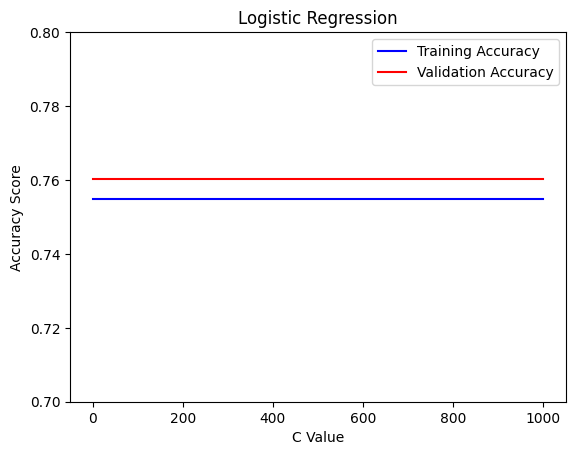

In [65]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], training_acc_lst, 'b') 
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], testing_acc_lst,'r') 
plt.xlabel("C Value")
plt.ylabel("Accuracy Score")
plt.ylim(0.7,0.8)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.title('Logistic Regression')

## Logistic Regression with L1 Regularizaton

In [66]:
training_acc_lst_l1 = []
testing_acc_lst_l1 = []
max_test_acc_l1 = -1
max_c_l1 = -1

for c in [0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0]:
    model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=c)
    model_l1.fit(X_train_scale, y_train)
    results_l1 = evaluate_model(model_l1, X_train_scale, X_test_scale, y_train, y_test)
    training_acc_lst_l1.append(results_l1[0])
    testing_acc_lst_l1.append(results_l1[1])
    print(f"c = {c}\ntraining accuracy: {results_l1[0]}\nvalidation accuracy: {results_l1[1]}\n")
    if (results_l1[1] > max_test_acc_l1):
        max_test_acc_l1 = results_l1[1]
        max_c_l1 = c
best_model["log_reg_l1"] = (max_test_acc_l1, max_c_l1)
print(max_test_acc_l1)
print(max_c_l1)

c = 0.0001
training accuracy: 0.7289924332935086
validation accuracy: 0.7431302270011948

c = 0.001
training accuracy: 0.7534182928448161
validation accuracy: 0.7618478693747511

c = 0.01
training accuracy: 0.7542811628833134
validation accuracy: 0.7606531262445241

c = 0.1
training accuracy: 0.7551440329218106
validation accuracy: 0.7606531262445241

c = 1.0
training accuracy: 0.7548785344484269
validation accuracy: 0.7602548785344484

c = 10.0
training accuracy: 0.754812159830081
validation accuracy: 0.7604540023894862

c = 100.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 1000.0
training accuracy: 0.7548785344484269
validation accuracy: 0.7604540023894862

0.7618478693747511
0.001


Text(0.5, 1.0, 'Logistic Regression with L1 Regularization')

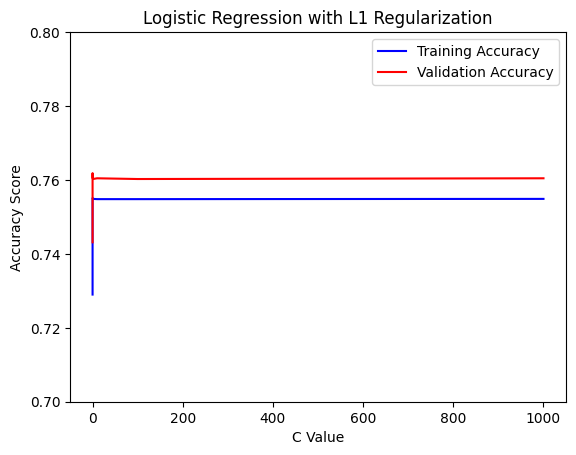

In [67]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], training_acc_lst_l1, 'b') 
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], testing_acc_lst_l1,'r') 
plt.xlabel("C Value")
plt.ylabel("Accuracy Score")
plt.ylim(0.7,0.8)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.title('Logistic Regression with L1 Regularization')

## Logistic Regression with L2 Regularizaton

In [68]:
training_acc_lst_l2 = []
testing_acc_lst_l2 = []
max_test_acc_l2 = -1
max_c_l2 = -1

for c in [0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0]:
    model_l2 = LogisticRegression(penalty='l2', solver='liblinear', C=c)
    model_l2.fit(X_train_scale, y_train)
    results_l2 = evaluate_model(model_l2, X_train_scale, X_test_scale, y_train, y_test)
    training_acc_lst_l2.append(results_l2[0])
    testing_acc_lst_l2.append(results_l2[1])
    print(f"c = {c}\ntraining accuracy: {results_l2[0]}\nvalidation accuracy: {results_l2[1]}\n")
    if (results_l2[1] > max_test_acc_l2):
        max_test_acc_l2 = results_l2[1]
        max_c_l2 = c
best_model["log_reg_l2"] = (max_test_acc_l2, max_c_l2)
print(max_test_acc_l2)
print(max_c_l2)

c = 0.0001
training accuracy: 0.7521571750962432
validation accuracy: 0.7594583831142971

c = 0.001
training accuracy: 0.7534182928448161
validation accuracy: 0.7606531262445241

c = 0.01
training accuracy: 0.7549449090667729
validation accuracy: 0.7602548785344484

c = 0.1
training accuracy: 0.754812159830081
validation accuracy: 0.7606531262445241

c = 1.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 10.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 100.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 1000.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

0.7606531262445241
0.001


Text(0.5, 1.0, 'Logistic Regression with L2 Regularization')

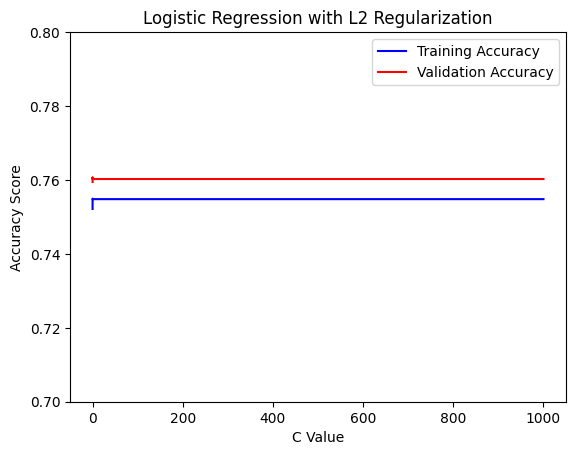

In [69]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], training_acc_lst_l2, 'b') 
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], testing_acc_lst_l2,'r') 
plt.xlabel("C Value")
plt.ylabel("Accuracy Score")
plt.ylim(0.7,0.8)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.title('Logistic Regression with L2 Regularization')

## Logistic Regresion with Polynomial Transformation X^2

In [70]:
poly2 = PolynomialFeatures(degree=2)
X_train_poly2 = poly2.fit_transform(X_train_scale)
X_test_poly2 = poly2.transform(X_test_scale)
print(X_train_poly2, X_test_poly2)

[[ 1.00000000e+00  4.94216191e+00 -4.71061536e+00 ...  3.60902700e-03
  -5.64300746e-02  8.82330146e-01]
 [ 1.00000000e+00 -1.44848748e+00  3.19123230e+00 ...  1.20763663e+01
  -3.26425214e+00  8.82330146e-01]
 [ 1.00000000e+00  2.61278667e+00 -1.38028544e+00 ...  3.60902700e-03
   1.83984681e-01  9.37935987e+00]
 ...
 [ 1.00000000e+00 -1.10931466e+00 -3.08597317e-01 ...  3.60902700e-03
   1.83984681e-01  9.37935987e+00]
 [ 1.00000000e+00 -2.27374321e+00  3.91622074e-01 ...  3.60902700e-03
   1.83984681e-01  9.37935987e+00]
 [ 1.00000000e+00  2.23223948e+00 -1.71590319e+00 ...  3.60902700e-03
  -5.64300746e-02  8.82330146e-01]] [[ 1.00000000e+00 -4.30584084e+00  4.94457085e+00 ...  3.60902700e-03
   1.83984681e-01  9.37935987e+00]
 [ 1.00000000e+00  1.69016757e+00  3.78125924e-01 ...  3.60902700e-03
  -5.64300746e-02  8.82330146e-01]
 [ 1.00000000e+00 -9.06133987e-02  6.21218825e-01 ...  1.20763663e+01
  -3.26425214e+00  8.82330146e-01]
 ...
 [ 1.00000000e+00 -1.53111284e+00  2.0800137

In [71]:
training_acc_lst_poly2 = []
testing_acc_lst_poly2 = []
max_test_acc_poly2 = -1
max_c_poly2 = -1

for c in [0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0]:
    model_poly2 = LogisticRegression(penalty=None, C=c)
    model_poly2.fit(X_train_scale, y_train)
    results_poly2 = evaluate_model(model_poly2, X_train_scale, X_test_scale, y_train, y_test)
    training_acc_lst_poly2.append(results_poly2[0])
    testing_acc_lst_poly2.append(results_poly2[1])
    print(f"c = {c}\ntraining accuracy: {results_poly2[0]}\nvalidation accuracy: {results_poly2[1]}\n")
    if (results_poly2[1] > max_test_acc_poly2):
        max_test_acc_poly2 = results_poly2[1]
        max_c_poly2 = c
best_model["log_reg_poly2"] = (max_test_acc_poly2, max_c_poly2)
print(max_test_acc_poly2)
print(max_c_poly2)

c = 0.0001
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 0.001
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 0.01
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 0.1
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 1.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 10.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 100.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 1000.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

0.7602548785344484
0.0001


c:\Users\Jia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Jia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Jia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Jia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Jia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio paramete

Text(0.5, 1.0, 'Logistic Regression with Polynomial Transformation X^2')

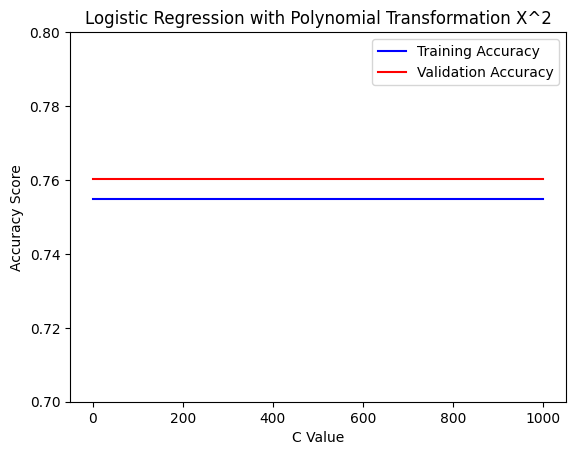

In [72]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], training_acc_lst_poly2, 'b') 
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], testing_acc_lst_poly2,'r') 
plt.xlabel("C Value")
plt.ylabel("Accuracy Score")
plt.ylim(0.7,0.8)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.title('Logistic Regression with Polynomial Transformation X^2')

## Logistic Regression with Polynomial Transformation X^2 and L1 Regularization

In [73]:
training_acc_lst_poly2_l1 = []
testing_acc_lst_poly2_l1 = []
max_test_acc_poly2_l1 = -1
max_c_poly2_l1 = -1

for c in [0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0]:
    model_poly2_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=c)
    model_poly2_l1.fit(X_train_scale, y_train)
    results_poly2_l1 = evaluate_model(model_poly2_l1, X_train_scale, X_test_scale, y_train, y_test)
    training_acc_lst_poly2_l1.append(results_poly2_l1[0])
    testing_acc_lst_poly2_l1.append(results_poly2_l1[1])
    print(f"c = {c}\ntraining accuracy: {results_poly2_l1[0]}\nvalidation accuracy: {results_poly2_l1[1]}\n")
    if (results_poly2_l1[1] > max_test_acc_poly2_l1):
        max_test_acc_poly2_l1 = results_poly2_l1[1]
        max_c_poly2_l1 = c
best_model["log_reg_poly2_l1"] = (max_test_acc_poly2_l1, max_c_poly2_l1)
print(max_test_acc_poly2_l1)
print(max_c_poly2_l1)

c = 0.0001
training accuracy: 0.7289924332935086
validation accuracy: 0.7431302270011948

c = 0.001
training accuracy: 0.7534846674631621
validation accuracy: 0.762046993229789

c = 0.01
training accuracy: 0.7542811628833134
validation accuracy: 0.7606531262445241

c = 0.1
training accuracy: 0.7552767821585026
validation accuracy: 0.7602548785344484

c = 1.0
training accuracy: 0.7548785344484269
validation accuracy: 0.7604540023894862

c = 10.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 100.0
training accuracy: 0.754812159830081
validation accuracy: 0.7604540023894862

c = 1000.0
training accuracy: 0.754812159830081
validation accuracy: 0.7604540023894862

0.762046993229789
0.001


Text(0.5, 1.0, 'Logistic Regression with Polynomial Transformation X^2 and L1 Regularization')

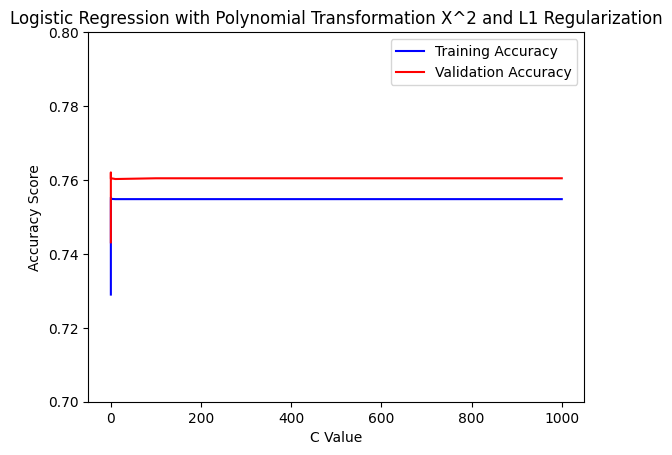

In [74]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], training_acc_lst_poly2_l1, 'b') 
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], testing_acc_lst_poly2_l1,'r') 
plt.xlabel("C Value")
plt.ylabel("Accuracy Score")
plt.ylim(0.7,0.8)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.title('Logistic Regression with Polynomial Transformation X^2 and L1 Regularization')

## Logistic Regression with Polynomial Transformation X^2 and L2 Regularization

In [75]:
training_acc_lst_poly2_l2 = []
testing_acc_lst_poly2_l2 = []
max_test_acc_poly2_l2 = -1
max_c_poly2_l2 = -1

for c in [0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0]:
    model_poly2_l2 = LogisticRegression(penalty='l2', solver='liblinear', C=c)
    model_poly2_l2.fit(X_train_scale, y_train)
    results_poly2_l2 = evaluate_model(model_poly2_l2, X_train_scale, X_test_scale, y_train, y_test)
    training_acc_lst_poly2_l2.append(results_poly2_l2[0])
    testing_acc_lst_poly2_l2.append(results_poly2_l2[1])
    print(f"c = {c}\ntraining accuracy: {results_poly2_l2[0]}\nvalidation accuracy: {results_poly2_l2[1]}\n")
    if (results_poly2_l2[1] > max_test_acc_poly2_l2):
        max_test_acc_poly2_l2 = results_poly2_l2[1]
        max_c_poly2_l2 = c
best_model["log_reg_poly2_l2"] = (max_test_acc_poly2_l2, max_c_poly2_l2) 
print(max_test_acc_poly2_l2)
print(max_c_poly2_l2)

c = 0.0001
training accuracy: 0.7521571750962432
validation accuracy: 0.7594583831142971

c = 0.001
training accuracy: 0.7534182928448161
validation accuracy: 0.7606531262445241

c = 0.01
training accuracy: 0.7549449090667729
validation accuracy: 0.7602548785344484

c = 0.1
training accuracy: 0.754812159830081
validation accuracy: 0.7606531262445241

c = 1.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 10.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 100.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 1000.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

0.7606531262445241
0.001


Text(0.5, 1.0, 'Logistic Regression with Polynomial Transformation X^2 and L2 Regularization')

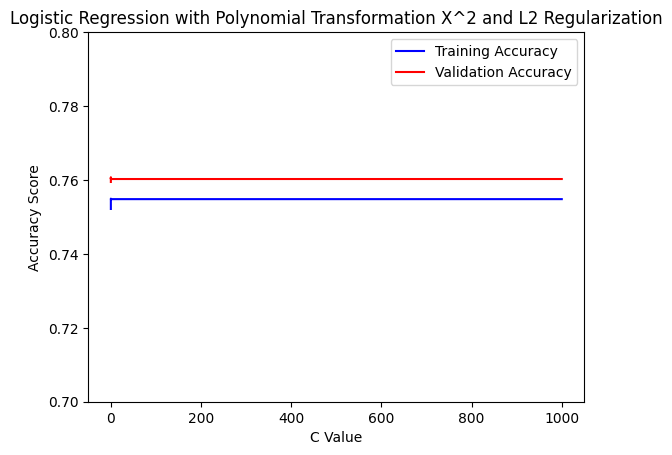

In [76]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], training_acc_lst_poly2_l2, 'b') 
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], testing_acc_lst_poly2_l2,'r') 
plt.xlabel("C Value")
plt.ylabel("Accuracy Score")
plt.ylim(0.7,0.8)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.title('Logistic Regression with Polynomial Transformation X^2 and L2 Regularization')

## Logistic Regresion with Polynomial Transformation X^3

In [77]:
poly3 = PolynomialFeatures(degree=3)
X_train_poly3 = poly3.fit_transform(X_train_scale)
X_test_poly3 = poly3.transform(X_test_scale)
print(X_train_poly3, X_test_poly3)

[[ 1.00000000e+00  4.94216191e+00 -4.71061536e+00 ...  3.39004677e-03
  -5.30061405e-02  8.28794149e-01]
 [ 1.00000000e+00 -1.44848748e+00  3.19123230e+00 ...  1.13436244e+01
  -3.06619137e+00  8.28794149e-01]
 [ 1.00000000e+00  2.61278667e+00 -1.38028544e+00 ... -1.10529125e-02
  -5.63466713e-01 -2.87249842e+01]
 ...
 [ 1.00000000e+00 -1.10931466e+00 -3.08597317e-01 ... -1.10529125e-02
  -5.63466713e-01 -2.87249842e+01]
 [ 1.00000000e+00 -2.27374321e+00  3.91622074e-01 ... -1.10529125e-02
  -5.63466713e-01 -2.87249842e+01]
 [ 1.00000000e+00  2.23223948e+00 -1.71590319e+00 ...  3.39004677e-03
  -5.30061405e-02  8.28794149e-01]] [[ 1.00000000e+00 -4.30584084e+00  4.94457085e+00 ... -1.10529125e-02
  -5.63466713e-01 -2.87249842e+01]
 [ 1.00000000e+00  1.69016757e+00  3.78125924e-01 ...  3.39004677e-03
  -5.30061405e-02  8.28794149e-01]
 [ 1.00000000e+00 -9.06133987e-02  6.21218825e-01 ...  1.13436244e+01
  -3.06619137e+00  8.28794149e-01]
 ...
 [ 1.00000000e+00 -1.53111284e+00  2.0800137

In [78]:
training_acc_lst_poly3 = []
testing_acc_lst_poly3 = []
max_test_acc_poly3 = -1
max_c_poly3 = -1

for c in [0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0]:
    model_poly3 = LogisticRegression(penalty=None, C=c)
    model_poly3.fit(X_train_scale, y_train)
    results_poly3 = evaluate_model(model_poly3, X_train_scale, X_test_scale, y_train, y_test)
    training_acc_lst_poly3.append(results_poly3[0])
    testing_acc_lst_poly3.append(results_poly3[1])
    print(f"c = {c}\ntraining accuracy: {results_poly3[0]}\nvalidation accuracy: {results_poly3[1]}\n")
    if (results_poly3[1] > max_test_acc_poly3):
        max_test_acc_poly3 = results_poly3[1]
        max_c_poly3 = c
best_model["log_reg_poly3"] = (max_test_acc_poly3, max_c_poly3)
print(max_test_acc_poly3)
print(max_c_poly3)

c = 0.0001
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 0.001
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 0.01
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 0.1
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 1.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 10.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 100.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 1000.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

0.7602548785344484
0.0001


c:\Users\Jia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Jia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Jia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Jia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Jia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio paramete

Text(0.5, 1.0, 'Logistic Regression with Polynomial Transformation X^3')

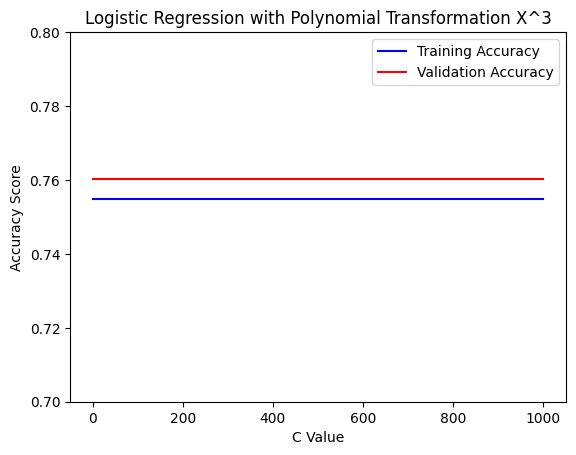

In [79]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], training_acc_lst_poly3, 'b') 
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], testing_acc_lst_poly3,'r') 
plt.xlabel("C Value")
plt.ylabel("Accuracy Score")
plt.ylim(0.7,0.8)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.title('Logistic Regression with Polynomial Transformation X^3')

## Logistic Regresion with Polynomial Transformation X^3 with L1 Regularization

In [80]:
training_acc_lst_poly3_l1 = []
testing_acc_lst_poly3_l1 = []
max_test_acc_poly3_l1 = -1
max_c_poly3_l1 = -1

for c in [0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0]:
    model_poly3_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=c)
    model_poly3_l1.fit(X_train_scale, y_train)
    results_poly3_l1 = evaluate_model(model_poly3_l1, X_train_scale, X_test_scale, y_train, y_test)
    training_acc_lst_poly3_l1.append(results_poly3_l1[0])
    testing_acc_lst_poly3_l1.append(results_poly3_l1[1])
    print(f"c = {c}\ntraining accuracy: {results_poly3_l1[0]}\nvalidation accuracy: {results_poly3_l1[1]}\n")
    if (results_poly3_l1[1] > max_test_acc_poly3_l1):
        max_test_acc_poly3_l1 = results_poly3_l1[1]
        max_c_poly3_l1 = c
best_model["log_reg_poly3_l1"] = (max_test_acc_poly3_l1, max_c_poly3_l1)
print(max_test_acc_poly3_l1)
print(max_c_poly3_l1)

c = 0.0001
training accuracy: 0.7289924332935086
validation accuracy: 0.7431302270011948

c = 0.001
training accuracy: 0.7534182928448161
validation accuracy: 0.7618478693747511

c = 0.01
training accuracy: 0.7542811628833134
validation accuracy: 0.7606531262445241

c = 0.1
training accuracy: 0.7552767821585026
validation accuracy: 0.7602548785344484

c = 1.0
training accuracy: 0.7548785344484269
validation accuracy: 0.7604540023894862

c = 10.0
training accuracy: 0.754812159830081
validation accuracy: 0.7604540023894862

c = 100.0
training accuracy: 0.7548785344484269
validation accuracy: 0.7604540023894862

c = 1000.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

0.7618478693747511
0.001


Text(0.5, 1.0, 'Logistic Regression with Polynomial Transformation X^3 and L1 Regularization')

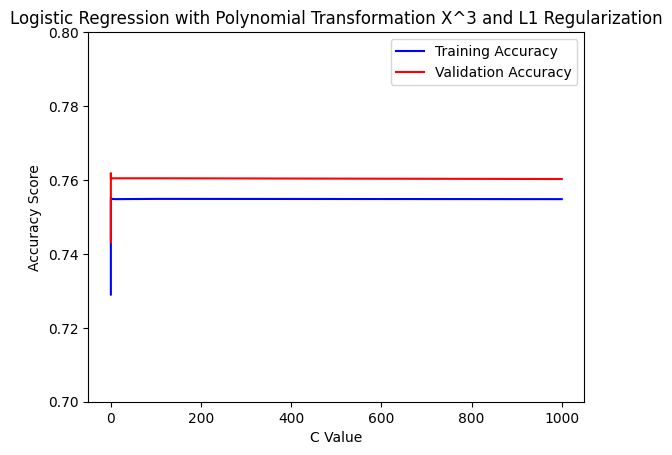

In [81]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], training_acc_lst_poly3_l1, 'b') 
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], testing_acc_lst_poly3_l1,'r') 
plt.xlabel("C Value")
plt.ylabel("Accuracy Score")
plt.ylim(0.7,0.8)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.title('Logistic Regression with Polynomial Transformation X^3 and L1 Regularization')

## Logistic Regresion with Polynomial Transformation X^3 with L2 Regularization

In [82]:
training_acc_lst_poly3_l2 = []
testing_acc_lst_poly3_l2 = []
max_test_acc_poly3_l2 = -1
max_c_poly3_l2 = -1

for c in [0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0]:
    model_poly3_l2 = LogisticRegression(penalty='l2', solver='liblinear', C=c)
    model_poly3_l2.fit(X_train_scale, y_train)
    results_poly3_l2 = evaluate_model(model_poly3_l2, X_train_scale, X_test_scale, y_train, y_test)
    training_acc_lst_poly3_l2.append(results_poly3_l2[0])
    testing_acc_lst_poly3_l2.append(results_poly3_l2[1])
    print(f"c = {c}\ntraining accuracy: {results_poly3_l2[0]}\nvalidation accuracy: {results_poly3_l2[1]}\n")
    if (results_poly3_l2[1] > max_test_acc_poly3_l2):
        max_test_acc_poly3_l2 = results_poly3_l2[1]
        max_c_poly3_l2 = c
best_model["log_reg_poly3_l2"] = (max_test_acc_poly3_l2, max_c_poly3_l2)
print(max_test_acc_poly3_l2)
print(max_c_poly3_l2)

c = 0.0001
training accuracy: 0.7521571750962432
validation accuracy: 0.7594583831142971

c = 0.001
training accuracy: 0.7534182928448161
validation accuracy: 0.7606531262445241

c = 0.01
training accuracy: 0.7549449090667729
validation accuracy: 0.7602548785344484

c = 0.1
training accuracy: 0.754812159830081
validation accuracy: 0.7606531262445241

c = 1.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 10.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 100.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

c = 1000.0
training accuracy: 0.754812159830081
validation accuracy: 0.7602548785344484

0.7606531262445241
0.001


Text(0.5, 1.0, 'Logistic Regression with Polynomial Transformation X^3 and L2 Regularization')

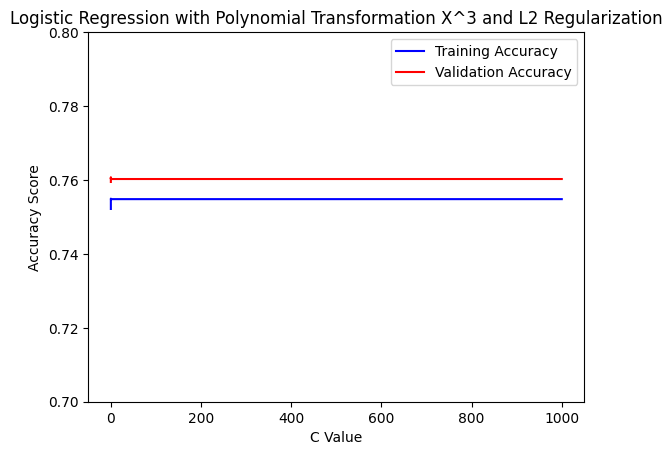

In [83]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], training_acc_lst_poly3_l2, 'b') 
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0, 100.0, 1000.0], testing_acc_lst_poly3_l2,'r') 
plt.xlabel("C Value")
plt.ylabel("Accuracy Score")
plt.ylim(0.7,0.8)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.title('Logistic Regression with Polynomial Transformation X^3 and L2 Regularization')

## Logistic Regression Confusion Matrix

In [88]:
max_acc = -1
best_log_reg = ""
for key in best_model:
    if best_model[key][0] > max_acc:
        max_acc = best_model[key][0]
        best_log_reg = key
print(best_log_reg)
print(max_acc)

log_reg_poly2_l1
0.762046993229789


In [90]:
model_poly2_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=best_model[best_log_reg][1])
model_poly2_l1.fit(X_train_scale, y_train)
results_poly2_l1 = evaluate_model(model_poly2_l1, X_train_scale, X_test_scale, y_train, y_test)
model_poly2_l1_pred = model_poly2_l1.predict(X_test_scale)

Text(0.5, 1.0, 'Logistric Regression Matrix')

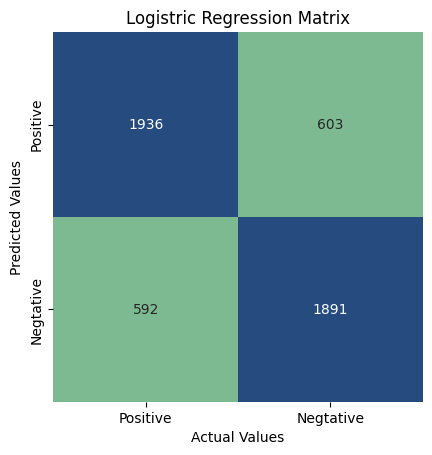

In [114]:
mat = confusion_matrix(y_test, model_poly2_l1_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap=sns.color_palette("crest"),
cbar=False, xticklabels=['Positive','Negtative'], yticklabels=['Positive','Negtative'])
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title("Logistric Regression Matrix")

## SVM

## Neural Network with One Hidden Layer

In [96]:
best_nn = {}

In [36]:
nn1 = Sequential([
    Dense(50, activation='relu', input_shape=(X_train_scale.shape[1],)),
    Dense(1, activation='sigmoid')
])

nn1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
nn1.summary()

c:\Users\Jia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401 (1.57 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history1 = nn1.fit(X_train_scale, y_train, epochs=50, batch_size=32, validation_split=0.2)
train_eval1 = nn1.evaluate(X_train_scale, y_train)
test_eval1 = nn1.evaluate(X_test_scale, y_test)

print(train_eval1)
print(test_eval1)

Epoch 1/50


377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Precision: 0.6540 - Recall: 0.6394 - accuracy: 0.6435 - loss: 0.6011 - val_Precision: 0.7384 - val_Recall: 0.7969 - val_accuracy: 0.7502 - val_loss: 0.4974
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - Precision: 0.7542 - Recall: 0.7651 - accuracy: 0.7508 - loss: 0.5022 - val_Precision: 0.7449 - val_Recall: 0.7776 - val_accuracy: 0.7485 - val_loss: 0.4965
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - Precision: 0.7661 - Recall: 0.7707 - accuracy: 0.7554 - loss: 0.4981 - val_Precision: 0.7498 - val_Recall: 0.7692 - val_accuracy: 0.7492 - val_loss: 0.4958
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - Precision: 0.7662 - Recall: 0.7689 - accuracy: 0.7568 - loss: 0.4879 - val_Precision: 0.7524 - val_Recall: 0.7718 - val_accuracy: 0.7518 - val_loss: 0.4946
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - Precision: 0.7609 - Recall: 0.7622 - accuracy: 0.7566 - loss: 0.4935 - val_Precision: 0.7475 - val_Recall: 0.

In [97]:
best_nn["layer1"] = (test_eval1[1], 0)

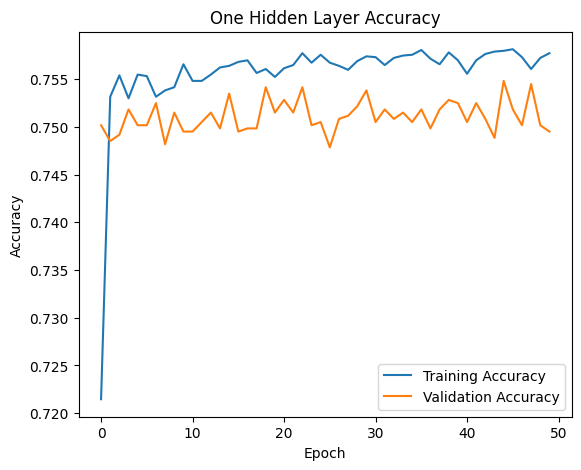

In [38]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('One Hidden Layer Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Neural Network with Two Hidden Layer

In [39]:
nn2 = Sequential([
    Dense(50, activation='relu', input_shape=(X_train_scale.shape[1],)),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
nn2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 50)             │           350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,651 (6.45 KB)

 Trainable params: 1,651 (6.45 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history2 = nn2.fit(X_train_scale, y_train, epochs=50, batch_size=32, validation_split=0.2)
train_eval2 = nn2.evaluate(X_train_scale, y_train)
test_eval2 = nn2.evaluate(X_test_scale, y_test)

print(train_eval2)
print(test_eval2)

Epoch 1/50


377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Precision: 0.7431 - Recall: 0.7202 - accuracy: 0.7303 - loss: 0.5302 - val_Precision: 0.7524 - val_Recall: 0.7544 - val_accuracy: 0.7459 - val_loss: 0.4978
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - Precision: 0.7569 - Recall: 0.7677 - accuracy: 0.7520 - loss: 0.5005 - val_Precision: 0.7615 - val_Recall: 0.7595 - val_accuracy: 0.7538 - val_loss: 0.4988
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - Precision: 0.7562 - Recall: 0.7638 - accuracy: 0.7514 - loss: 0.4943 - val_Precision: 0.7383 - val_Recall: 0.7911 - val_accuracy: 0.7482 - val_loss: 0.4967
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - Precision: 0.7572 - Recall: 0.7874 - accuracy: 0.7584 - loss: 0.4872 - val_Precision: 0.7544 - val_Recall: 0.7524 - val_accuracy: 0.7465 - val_loss: 0.4966
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - Precision: 0.7658 - Recall: 0.7831 - accuracy: 0.7595 - loss: 0.4867 - val_Precision: 0.7634 - val_Recall: 0.

In [98]:
best_nn["layer2"] = (test_eval2[1], 0)

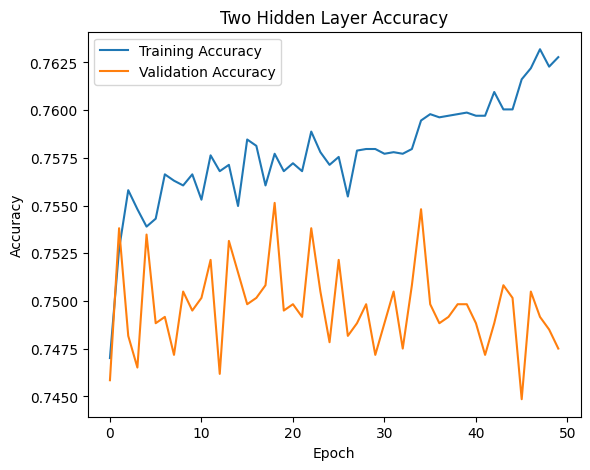

In [41]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Two Hidden Layer Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Neural Network with Three Hidden Layer

In [42]:
nn3 = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_scale.shape[1],)),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
nn3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 100)            │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,051 (27.54 KB)

 Trainable params: 7,051 (27.54 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
history3 = nn3.fit(X_train_scale, y_train, epochs=50, batch_size=32, validation_split=0.2)
train_eval3 = nn3.evaluate(X_train_scale, y_train)
test_eval3 = nn3.evaluate(X_test_scale, y_test)

print(train_eval3)
print(test_eval3)

Epoch 1/50


377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Precision: 0.7574 - Recall: 0.7170 - accuracy: 0.7342 - loss: 0.5272 - val_Precision: 0.7732 - val_Recall: 0.7299 - val_accuracy: 0.7508 - val_loss: 0.4996
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - Precision: 0.7647 - Recall: 0.7571 - accuracy: 0.7554 - loss: 0.4906 - val_Precision: 0.7551 - val_Recall: 0.7576 - val_accuracy: 0.7488 - val_loss: 0.4965
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - Precision: 0.7642 - Recall: 0.7788 - accuracy: 0.7597 - loss: 0.4915 - val_Precision: 0.7687 - val_Recall: 0.7350 - val_accuracy: 0.7498 - val_loss: 0.4969
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - Precision: 0.7686 - Recall: 0.7664 - accuracy: 0.7573 - loss: 0.4913 - val_Precision: 0.7524 - val_Recall: 0.7640 - val_accuracy: 0.7492 - val_loss: 0.4951
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - Precision: 0.7644 - Recall: 0.7574 - accuracy: 0.7561 - loss: 0.4927 - val_Precision: 0.7358 - val_Recall: 0.

In [99]:
best_nn["layer3"] = (test_eval3[1], 0)

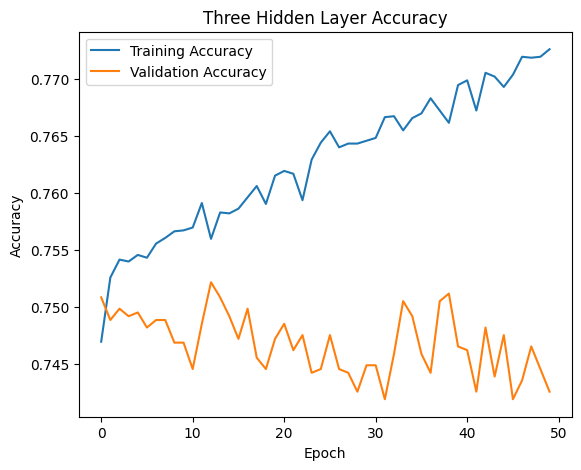

In [44]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Three Hidden Layer Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Neural Network with One Hidden Layer and L1 Regularization

In [45]:
training_acc_lst_l1_1 = []
testing_acc_lst_l1_1 = []
max_test_acc_l1_1 = -1
max_l_l1_1 = -1
max_history1_l1 = None

for l in [0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0]:
    nn1_l1 = Sequential([
        Dense(50, activation='relu', input_shape=(X_train_scale.shape[1],), kernel_regularizer=l1(l)),
        Dense(1, activation='sigmoid', kernel_regularizer=l1(l))
    ])

    nn1_l1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

    history1_l1 = nn1_l1.fit(X_train_scale, y_train, epochs=50, batch_size=32, validation_split=0.2)
    train_eval1_l1 = nn1_l1.evaluate(X_train_scale, y_train)
    test_eval1_l1 = nn1_l1.evaluate(X_test_scale, y_test)

    print(f"lambda = {l}\ntraining accuracy: {train_eval1_l1[1]}\nvalidation accuracy: {test_eval1_l1[1]}\n")

    training_acc_lst_l1_1.append(train_eval1_l1[1])
    testing_acc_lst_l1_1.append(test_eval1_l1[1])

    if (test_eval1_l1[1] > max_test_acc_l1_1):
        max_test_acc_l1_1 = test_eval1_l1[1]
        max_l_l1_1 = l
        max_history1_l1 = history1_l1
print(max_test_acc_l1_1)
print(max_l_l1_1)

Epoch 1/50


377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Precision: 0.6910 - Recall: 0.8064 - accuracy: 0.7088 - loss: 0.5656 - val_Precision: 0.7524 - val_Recall: 0.7621 - val_accuracy: 0.7485 - val_loss: 0.5007
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - Precision: 0.7584 - Recall: 0.7695 - accuracy: 0.7572 - loss: 0.4939 - val_Precision: 0.7516 - val_Recall: 0.7589 - val_accuracy: 0.7468 - val_loss: 0.5013
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - Precision: 0.7560 - Recall: 0.7645 - accuracy: 0.7538 - loss: 0.5053 - val_Precision: 0.7560 - val_Recall: 0.7569 - val_accuracy: 0.7492 - val_loss: 0.5015
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - Precision: 0.7609 - Recall: 0.7757 - accuracy: 0.7583 - loss: 0.4947 - val_Precision: 0.7532 - val_Recall: 0.7556 - val_accuracy: 0.7468 - val_loss: 0.5001
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - Precision: 0.7644 - Recall: 0.7665 - accuracy: 0.7558 - loss: 0.4975 - val_Precision: 0.7486 - val_Recall: 0.

In [100]:
best_nn["layer1_l1"] = (max_test_acc_l1_1, max_l_l1_1)

Text(0.5, 1.0, 'One Hidden Layer with L1 Regularization Lambda Value')

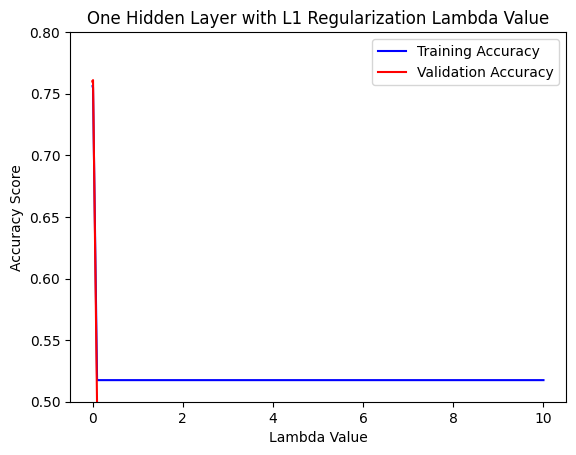

In [46]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0], training_acc_lst_l1_1, 'b') 
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0], testing_acc_lst_l1_1,'r') 
plt.xlabel("Lambda Value")
plt.ylabel("Accuracy Score")
plt.ylim(0.5,0.8)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.title('One Hidden Layer with L1 Regularization Lambda Value')

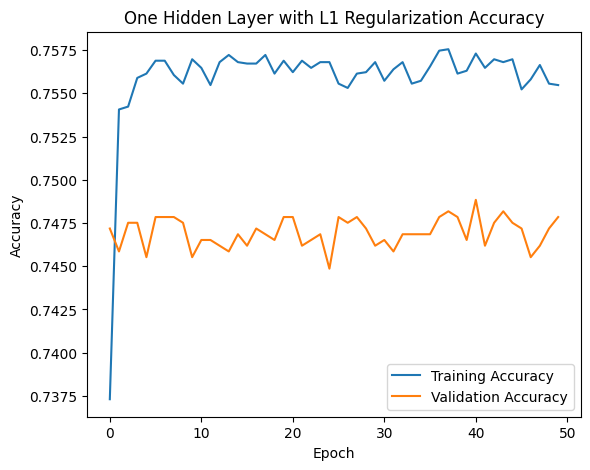

In [47]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(max_history1_l1.history['accuracy'], label='Training Accuracy')
plt.plot(max_history1_l1.history['val_accuracy'], label='Validation Accuracy')
plt.title('One Hidden Layer with L1 Regularization Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Neural Network with Two Hidden Layer and L1 Regularization

In [48]:
training_acc_lst_l1_2 = []
testing_acc_lst_l1_2 = []
max_test_acc_l1_2 = -1
max_l_l1_2 = -1
max_history2_l1 = None

for l in [0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0]:
    nn2_l1 = Sequential([
        Dense(50, activation='relu', input_shape=(X_train_scale.shape[1],), kernel_regularizer=l1(l)),
        Dense(25, activation='relu', kernel_regularizer=l1(l)),
        Dense(1, activation='sigmoid', kernel_regularizer=l1(l))
    ])

    nn2_l1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

    history2_l1 = nn2_l1.fit(X_train_scale, y_train, epochs=50, batch_size=32, validation_split=0.2)
    train_eval2_l1 = nn2_l1.evaluate(X_train_scale, y_train)
    test_eval2_l1 = nn2_l1.evaluate(X_test_scale, y_test)

    print(f"lambda = {l}\ntraining accuracy: {train_eval2_l1[1]}\nvalidation accuracy: {test_eval2_l1[1]}\n")

    training_acc_lst_l1_2.append(train_eval2_l1[1])
    testing_acc_lst_l1_2.append(test_eval2_l1[1])

    if (test_eval2_l1[1] > max_test_acc_l1_2):
        max_test_acc_l1_2 = test_eval2_l1[1]
        max_l_l1_2 = l
        max_history2_l1 = history2_l1
print(max_test_acc_l1_2)
print(max_l_l1_2)

Epoch 1/50


377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Precision: 0.7435 - Recall: 0.7220 - accuracy: 0.7269 - loss: 0.5492 - val_Precision: 0.7539 - val_Recall: 0.7782 - val_accuracy: 0.7551 - val_loss: 0.5165
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - Precision: 0.7523 - Recall: 0.7534 - accuracy: 0.7463 - loss: 0.5196 - val_Precision: 0.7424 - val_Recall: 0.7840 - val_accuracy: 0.7488 - val_loss: 0.5149
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - Precision: 0.7584 - Recall: 0.7691 - accuracy: 0.7502 - loss: 0.5160 - val_Precision: 0.7579 - val_Recall: 0.7569 - val_accuracy: 0.7505 - val_loss: 0.5150
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - Precision: 0.7604 - Recall: 0.7689 - accuracy: 0.7534 - loss: 0.5109 - val_Precision: 0.7516 - val_Recall: 0.7666 - val_accuracy: 0.7495 - val_loss: 0.5110
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - Precision: 0.7643 - Recall: 0.7765 - accuracy: 0.7545 - loss: 0.5109 - val_Precision: 0.7497 - val_Recall: 0.

In [101]:
best_nn["layer2_l1"] = (max_test_acc_l1_2, max_l_l1_2)

Text(0.5, 1.0, 'Two Hidden Layer with L1 Regularization Lambda Value')

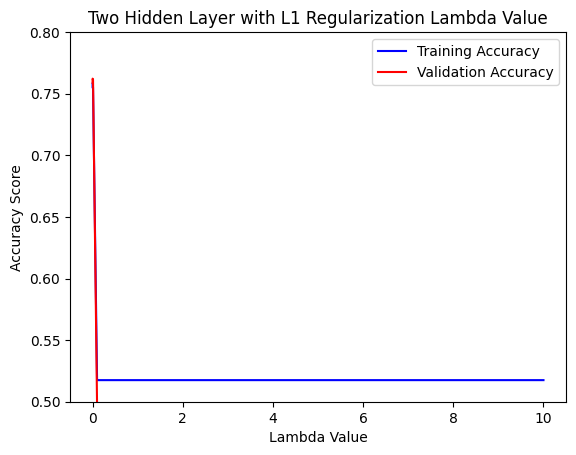

In [49]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0], training_acc_lst_l1_2, 'b') 
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0], testing_acc_lst_l1_2,'r') 
plt.xlabel("Lambda Value")
plt.ylabel("Accuracy Score")
plt.ylim(0.5,0.8)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.title('Two Hidden Layer with L1 Regularization Lambda Value')

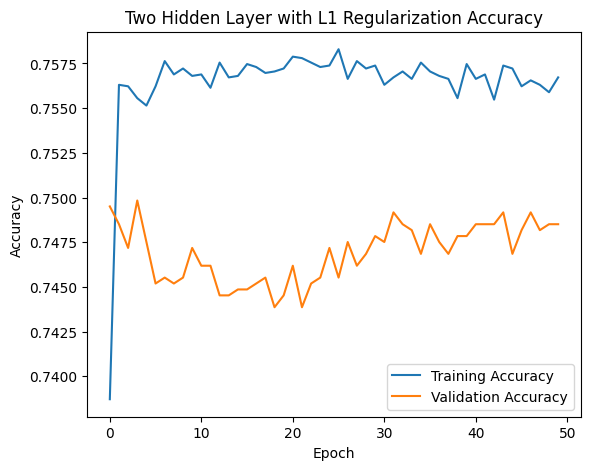

In [50]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(max_history2_l1.history['accuracy'], label='Training Accuracy')
plt.plot(max_history2_l1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Two Hidden Layer with L1 Regularization Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Neural Network with Three Hidden Layer and L1 Regularization

In [51]:
training_acc_lst_l1_3 = []
testing_acc_lst_l1_3 = []
max_test_acc_l1_3 = -1
max_l_l1_3 = -1
max_history3_l1 = None

for l in [0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0]:
    nn3_l1 = Sequential([
        Dense(100, activation='relu', input_shape=(X_train_scale.shape[1],), kernel_regularizer=l1(l)),
        Dense(50, activation='relu', kernel_regularizer=l1(l)),
        Dense(25, activation='relu', kernel_regularizer=l1(l)),
        Dense(1, activation='sigmoid', kernel_regularizer=l1(l))
    ])

    nn3_l1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

    history3_l1 = nn3_l1.fit(X_train_scale, y_train, epochs=50, batch_size=32, validation_split=0.2)
    train_eval3_l1 = nn3_l1.evaluate(X_train_scale, y_train)
    test_eval3_l1 = nn3_l1.evaluate(X_test_scale, y_test)

    print(f"lambda = {l}\ntraining accuracy: {train_eval3_l1[1]}\nvalidation accuracy: {test_eval3_l1[1]}\n")

    training_acc_lst_l1_3.append(train_eval3_l1[1])
    testing_acc_lst_l1_3.append(test_eval3_l1[1])

    if (test_eval3_l1[1] > max_test_acc_l1_3):
        max_test_acc_l1_3 = test_eval3_l1[1]
        max_l_l1_3 = l
        max_history3_l1 = history3_l1
print(max_test_acc_l1_3)
print(max_l_l1_3)

Epoch 1/50


377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.7404 - Recall: 0.7629 - accuracy: 0.7339 - loss: 0.5947 - val_Precision: 0.7545 - val_Recall: 0.7608 - val_accuracy: 0.7495 - val_loss: 0.5571
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - Precision: 0.7606 - Recall: 0.7630 - accuracy: 0.7531 - loss: 0.5518 - val_Precision: 0.7530 - val_Recall: 0.7685 - val_accuracy: 0.7512 - val_loss: 0.5455
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - Precision: 0.7510 - Recall: 0.7681 - accuracy: 0.7485 - loss: 0.5442 - val_Precision: 0.7609 - val_Recall: 0.7408 - val_accuracy: 0.7468 - val_loss: 0.5341
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - Precision: 0.7654 - Recall: 0.7713 - accuracy: 0.7561 - loss: 0.5286 - val_Precision: 0.7607 - val_Recall: 0.7479 - val_accuracy: 0.7492 - val_loss: 0.5277
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - Precision: 0.7568 - Recall: 0.7599 - accuracy: 0.7553 - loss: 0.5308 - val_Precision: 0.7617 - val_Recall: 0.

In [102]:
best_nn["layer3_l1"] = (max_test_acc_l1_3, max_l_l1_3)

Text(0.5, 1.0, 'Three Hidden Layer with L1 Regularization Lambda Value')

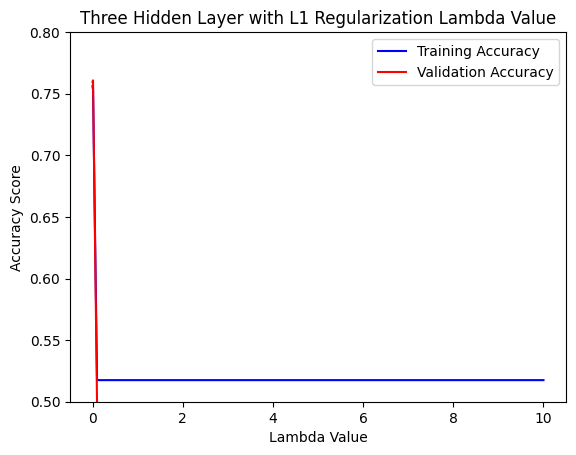

In [52]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0], training_acc_lst_l1_3, 'b') 
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0], testing_acc_lst_l1_3,'r') 
plt.xlabel("Lambda Value")
plt.ylabel("Accuracy Score")
plt.ylim(0.5,0.8)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.title('Three Hidden Layer with L1 Regularization Lambda Value')

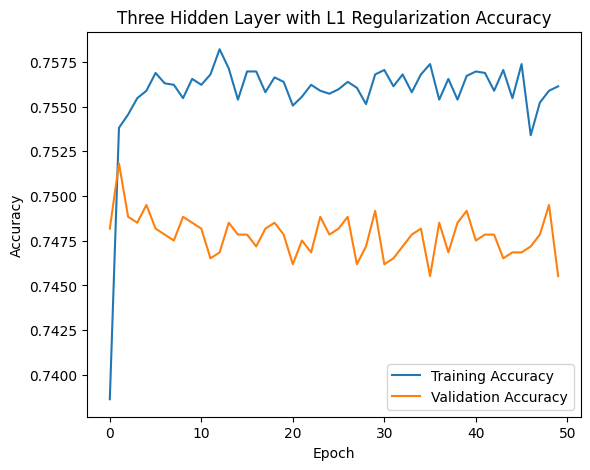

In [53]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(max_history3_l1.history['accuracy'], label='Training Accuracy')
plt.plot(max_history3_l1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Three Hidden Layer with L1 Regularization Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Neural Network with One Hidden Layer and L2 Regularization

In [54]:
training_acc_lst_l2_1 = []
testing_acc_lst_l2_1 = []
max_test_acc_l2_1 = -1
max_l_l2_1 = -1
max_history1_l2 = None

for l in [0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0]:
    nn1_l2 = Sequential([
        Dense(50, activation='relu', input_shape=(X_train_scale.shape[1],), kernel_regularizer=l2(l)),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(l))
    ])

    nn1_l2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

    history1_l2 = nn1_l2.fit(X_train_scale, y_train, epochs=50, batch_size=32, validation_split=0.2)
    train_eval2_l2 = nn1_l2.evaluate(X_train_scale, y_train)
    test_eval2_l2 = nn1_l2.evaluate(X_test_scale, y_test)

    print(f"lambda = {l}\ntraining accuracy: {train_eval2_l2[1]}\nvalidation accuracy: {test_eval2_l2[1]}\n")

    training_acc_lst_l2_1.append(train_eval2_l2[1])
    testing_acc_lst_l2_1.append(test_eval2_l2[1])

    if (test_eval2_l2[1] > max_test_acc_l2_1):
        max_test_acc_l2_1 = test_eval2_l2[1]
        max_l_l2_1 = l
        max_history1_l2 = history1_l2
print(max_test_acc_l2_1)
print(max_l_l2_1)

Epoch 1/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Precision: 0.7496 - Recall: 0.6491 - accuracy: 0.7069 - loss: 0.5453 - val_Precision: 0.7405 - val_Recall: 0.7801 - val_accuracy: 0.7462 - val_loss: 0.4984
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - Precision: 0.7510 - Recall: 0.7751 - accuracy: 0.7503 - loss: 0.4997 - val_Precision: 0.7502 - val_Recall: 0.7608 - val_accuracy: 0.7465 - val_loss: 0.4962
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - Precision: 0.7652 - Recall: 0.7664 - accuracy: 0.7567 - loss: 0.4921 - val_Precision: 0.7464 - val_Recall: 0.7685 - val_accuracy: 0.7465 - val_loss: 0.4979
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - Precision: 0.7531 - Recall: 0.7723 - accuracy: 0.7513 - loss: 0.4923 - val_Precision: 0.7570 - val_Recall: 0.7511 - val_accuracy: 0.7478 - val_loss: 0.4974
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - Precision: 0.7645 - Recall: 0.7728 - accuracy: 0.7572 - loss: 0.4934 - val_Precision: 0.7585 - val

In [103]:
best_nn["layer1_l2"] = (max_test_acc_l2_1, max_l_l2_1)

Text(0.5, 1.0, 'One Hidden Layer with L2 Regularization Lambda Value')

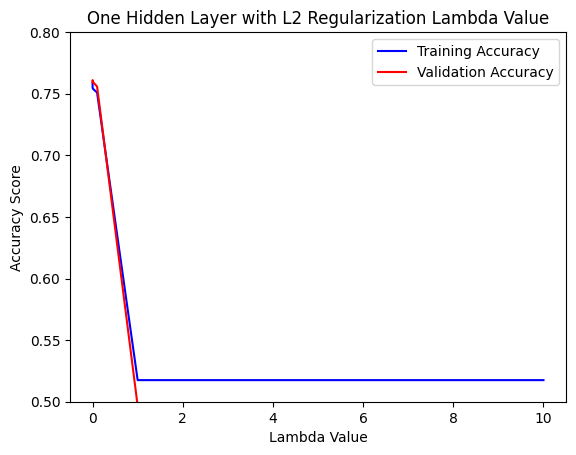

In [55]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0], training_acc_lst_l2_1, 'b') 
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0], testing_acc_lst_l2_1,'r') 
plt.xlabel("Lambda Value")
plt.ylabel("Accuracy Score")
plt.ylim(0.5,0.8)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.title('One Hidden Layer with L2 Regularization Lambda Value')

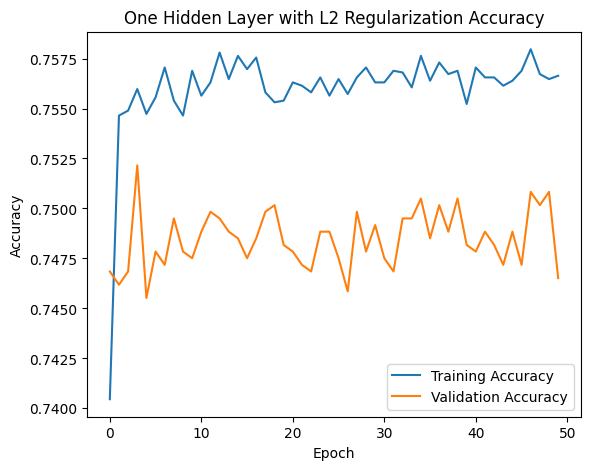

In [56]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(max_history1_l2.history['accuracy'], label='Training Accuracy')
plt.plot(max_history1_l2.history['val_accuracy'], label='Validation Accuracy')
plt.title('One Hidden Layer with L2 Regularization Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Neural Network with Two Hidden Layer and L2 Regularization

In [57]:
training_acc_lst_l2_2 = []
testing_acc_lst_l2_2 = []
max_test_acc_l2_2 = -1
max_l_l2_2 = -1
max_history2_l2 = None

for l in [0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0]:
    nn2_l2 = Sequential([
        Dense(50, activation='relu', input_shape=(X_train_scale.shape[1],), kernel_regularizer=l2(l)),
        Dense(25, activation='relu', kernel_regularizer=l2(l)),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(l))
    ])

    nn2_l2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

    history2_l2 = nn2_l2.fit(X_train_scale, y_train, epochs=50, batch_size=32, validation_split=0.2)
    train_eval2_l2 = nn2_l2.evaluate(X_train_scale, y_train)
    test_eval2_l2 = nn2_l2.evaluate(X_test_scale, y_test)

    print(f"lambda = {l}\ntraining accuracy: {train_eval2_l2[1]}\nvalidation accuracy: {test_eval2_l2[1]}\n")

    training_acc_lst_l2_2.append(train_eval2_l2[1])
    testing_acc_lst_l2_2.append(test_eval2_l2[1])

    if (test_eval2_l2[1] > max_test_acc_l2_2):
        max_test_acc_l2_2 = test_eval2_l2[1]
        max_l_l2_2 = l
        max_history2_l2 = history2_l2
print(max_test_acc_l2_2)
print(max_l_l2_2)

Epoch 1/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Precision: 0.7002 - Recall: 0.7255 - accuracy: 0.6905 - loss: 0.5668 - val_Precision: 0.7583 - val_Recall: 0.7524 - val_accuracy: 0.7492 - val_loss: 0.5013
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - Precision: 0.7664 - Recall: 0.7638 - accuracy: 0.7545 - loss: 0.4981 - val_Precision: 0.7593 - val_Recall: 0.7627 - val_accuracy: 0.7535 - val_loss: 0.4975
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - Precision: 0.7646 - Recall: 0.7729 - accuracy: 0.7593 - loss: 0.4939 - val_Precision: 0.7548 - val_Recall: 0.7660 - val_accuracy: 0.7515 - val_loss: 0.4981
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - Precision: 0.7702 - Recall: 0.7635 - accuracy: 0.7585 - loss: 0.4923 - val_Precision: 0.7454 - val_Recall: 0.7834 - val_accuracy: 0.7508 - val_loss: 0.4991
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - Precision: 0.7550 - Recall: 0.7813 - accuracy: 0.7535 - loss: 0.4965 - val_Precision: 0.7648 - val

In [104]:
best_nn["layer2_l2"] = (max_test_acc_l2_2, max_l_l2_2)

Text(0.5, 1.0, 'Two Hidden Layer with L2 Regularization Lambda Value')

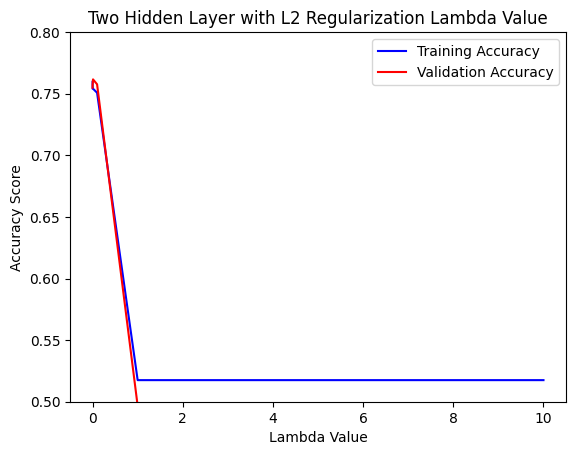

In [58]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0], training_acc_lst_l2_2, 'b') 
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0], testing_acc_lst_l2_2,'r') 
plt.xlabel("Lambda Value")
plt.ylabel("Accuracy Score")
plt.ylim(0.5,0.8)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.title('Two Hidden Layer with L2 Regularization Lambda Value')

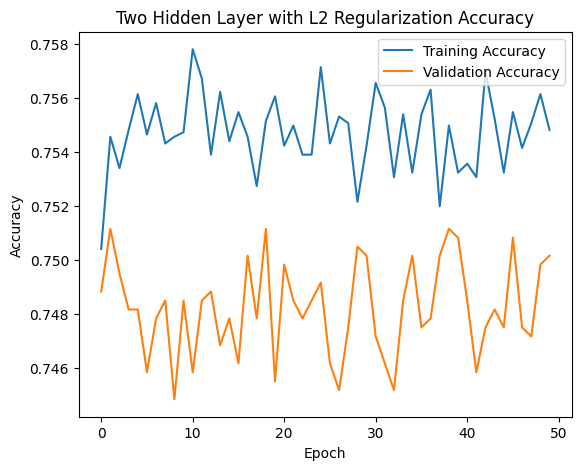

In [59]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(max_history2_l2.history['accuracy'], label='Training Accuracy')
plt.plot(max_history2_l2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Two Hidden Layer with L2 Regularization Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Neural Network with Three Hidden Layer and L2 Regularization

In [60]:
training_acc_lst_l2_3 = []
testing_acc_lst_l2_3 = []
max_test_acc_l2_3 = -1
max_l_l2_3 = -1
max_history3_l2 = None

for l in [0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0]:
    nn3_l2 = Sequential([
        Dense(100, activation='relu', input_shape=(X_train_scale.shape[1],), kernel_regularizer=l2(l)),
        Dense(50, activation='relu', kernel_regularizer=l2(l)),
        Dense(25, activation='relu', kernel_regularizer=l2(l)),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(l))
    ])

    nn3_l2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

    history3_l2 = nn3_l2.fit(X_train_scale, y_train, epochs=50, batch_size=32, validation_split=0.2)
    train_eval2_l2 = nn3_l2.evaluate(X_train_scale, y_train)
    test_eval2_l2 = nn3_l2.evaluate(X_test_scale, y_test)

    print(f"lambda = {l}\ntraining accuracy: {train_eval2_l2[1]}\nvalidation accuracy: {test_eval2_l2[1]}\n")

    training_acc_lst_l2_3.append(train_eval2_l2[1])
    testing_acc_lst_l2_3.append(test_eval2_l2[1])

    if (test_eval2_l2[1] > max_test_acc_l2_3):
        max_test_acc_l2_3 = test_eval2_l2[1]
        max_l_l2_3 = l
        max_history3_l2 = history3_l2
print(max_test_acc_l2_3)
print(max_l_l2_3)

Epoch 1/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Precision: 0.7505 - Recall: 0.7426 - accuracy: 0.7380 - loss: 0.5255 - val_Precision: 0.7497 - val_Recall: 0.7705 - val_accuracy: 0.7495 - val_loss: 0.5069
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - Precision: 0.7564 - Recall: 0.7657 - accuracy: 0.7535 - loss: 0.5068 - val_Precision: 0.7521 - val_Recall: 0.7647 - val_accuracy: 0.7492 - val_loss: 0.5067
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - Precision: 0.7600 - Recall: 0.7700 - accuracy: 0.7565 - loss: 0.5021 - val_Precision: 0.7561 - val_Recall: 0.7556 - val_accuracy: 0.7488 - val_loss: 0.5044
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - Precision: 0.7681 - Recall: 0.7585 - accuracy: 0.7551 - loss: 0.5035 - val_Precision: 0.7524 - val_Recall: 0.7698 - val_accuracy: 0.7512 - val_loss: 0.5031
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - Precision: 0.7618 - Recall: 0.7659 - accuracy: 0.7594 - loss: 0.5048 - val_Precision: 0.7422 - val

In [105]:
best_nn["layer3_l2"] = (max_test_acc_l2_3, max_l_l2_3)

Text(0.5, 1.0, 'Three Hidden Layer with L2 Regularization Lambda Value')

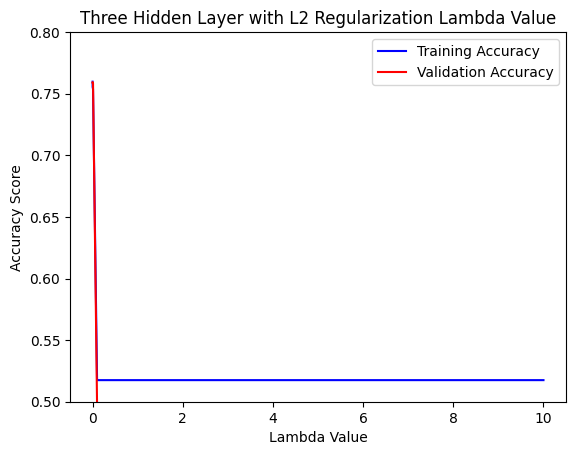

In [61]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0], training_acc_lst_l2_3, 'b') 
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0 ,10.0], testing_acc_lst_l2_3,'r') 
plt.xlabel("Lambda Value")
plt.ylabel("Accuracy Score")
plt.ylim(0.5,0.8)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.title('Three Hidden Layer with L2 Regularization Lambda Value')

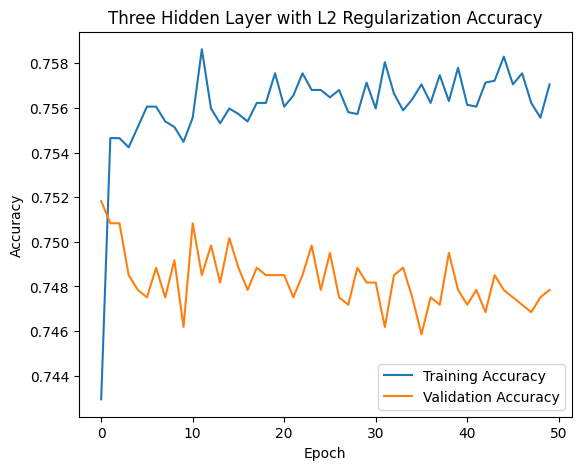

In [62]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(max_history3_l2.history['accuracy'], label='Training Accuracy')
plt.plot(max_history3_l2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Three Hidden Layer with L2 Regularization Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Neural Network Confusion Matrix

In [106]:
max_nn_acc = -1
best_nn_model = ""
for key in best_nn:
    if best_nn[key][0] > max_nn_acc:
        max_nn_acc = best_nn[key][0]
        best_nn_model = key
print(best_nn_model)
print(max_nn_acc)

layer2_l1
0.7622461318969727


In [108]:
nn2_l1 = Sequential([
    Dense(50, activation='relu', input_shape=(X_train_scale.shape[1],), kernel_regularizer=l1(best_nn[best_nn_model][1])),
    Dense(25, activation='relu', kernel_regularizer=l1(best_nn[best_nn_model][1])),
    Dense(1, activation='sigmoid', kernel_regularizer=l1(best_nn[best_nn_model][1]))
])

nn2_l1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

history2_l1 = nn2_l1.fit(X_train_scale, y_train, epochs=50, batch_size=32, validation_split=0.2)
train_eval2_l1 = nn2_l1.evaluate(X_train_scale, y_train)
test_eval2_l1 = nn2_l1.evaluate(X_test_scale, y_test)

Epoch 1/50


377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Precision: 0.7674 - Recall: 0.7438 - accuracy: 0.7473 - loss: 0.7118 - val_Precision: 0.7666 - val_Recall: 0.7453 - val_accuracy: 0.7522 - val_loss: 0.6216
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - Precision: 0.7651 - Recall: 0.7626 - accuracy: 0.7526 - loss: 0.6094 - val_Precision: 0.7634 - val_Recall: 0.7511 - val_accuracy: 0.7522 - val_loss: 0.5769
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - Precision: 0.7709 - Recall: 0.7612 - accuracy: 0.7568 - loss: 0.5690 - val_Precision: 0.7608 - val_Recall: 0.7485 - val_accuracy: 0.7495 - val_loss: 0.5553
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - Precision: 0.7700 - Recall: 0.7577 - accuracy: 0.7580 - loss: 0.5462 - val_Precision: 0.7475 - val_Recall: 0.7730 - val_accuracy: 0.7488 - val_loss: 0.5386
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - Precision: 0.7551 - Recall: 0.7695 - accuracy: 0.7541 - loss: 0.5419 - val_Precision: 0.7566 - val_Recall: 0.

In [110]:
predictions_prob = nn2_l1.predict(X_test_scale)
predictions = (predictions_prob > 0.5).astype(int)
print(predictions)

  1/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
[[0]
 [1]
 [1]
 ...
 [0]
 [1]
 [0]]


Text(0.5, 1.0, 'Neural Network Confusion Matrix')

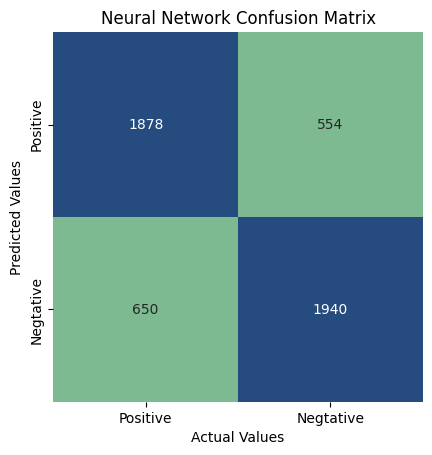

In [113]:
nn_mat = confusion_matrix(y_test, predictions)
sns.heatmap(nn_mat.T, square=True, annot=True, fmt='d', cmap=sns.color_palette("crest"),
cbar=False, xticklabels=['Positive','Negtative'], yticklabels=['Positive','Negtative'])
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title("Neural Network Confusion Matrix")